<a href="https://colab.research.google.com/github/Aravindhkannanb/fire-detection-using-image-processing/blob/main/fire_detection_96_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import cv2
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We load the data with glob

In [ ]:
lst_fire_img = glob.glob('/content/drive/MyDrive/fire_detection/fire/*.jpg')
lst_non_fire_img = glob.glob('/content/drive/MyDrive/fire_detection/non_fire/*.jpg')

In [ ]:
lst_non_fire_img

In [ ]:
print('Number of images with fire : {}'.format(len(lst_fire_img)))
print('Number of images with fire : {}'.format(len(lst_non_fire_img)))

Number of images with fire : 322
Number of images with fire : 471


In [ ]:
print(lst_fire_img)

['/content/drive/MyDrive/fire_detection/fire/img_83.jpg', '/content/drive/MyDrive/fire_detection/fire/img_82.jpg', '/content/drive/MyDrive/fire_detection/fire/img_81.jpg', '/content/drive/MyDrive/fire_detection/fire/img_84.jpg', '/content/drive/MyDrive/fire_detection/fire/img_88.jpg', '/content/drive/MyDrive/fire_detection/fire/img_86.jpg', '/content/drive/MyDrive/fire_detection/fire/img_87.jpg', '/content/drive/MyDrive/fire_detection/fire/img_85.jpg', '/content/drive/MyDrive/fire_detection/fire/img_89.jpg', '/content/drive/MyDrive/fire_detection/fire/img_96.jpg', '/content/drive/MyDrive/fire_detection/fire/img_92.jpg', '/content/drive/MyDrive/fire_detection/fire/img_91.jpg', '/content/drive/MyDrive/fire_detection/fire/img_93.jpg', '/content/drive/MyDrive/fire_detection/fire/img_90.jpg', '/content/drive/MyDrive/fire_detection/fire/img_103.jpg', '/content/drive/MyDrive/fire_detection/fire/img_94.jpg', '/content/drive/MyDrive/fire_detection/fire/img_102.jpg', '/content/drive/MyDrive/fire

In [ ]:
lst_images_random = random.sample(lst_fire_img,10) + random.sample(lst_non_fire_img,10)
random.shuffle(lst_images_random)

plt.figure(figsize = (20,20))

for i in range(len(lst_images_random)):
    
    plt.subplot(4,5,i+1)


    if "non_fire" in lst_images_random[i]:
        img = cv2.imread(lst_images_random[i])
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        plt.imshow(img)
        plt.title('Image without fire')

    else:
        img = cv2.imread(lst_images_random[i])
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        plt.imshow(img)
        plt.title("Image with fire")



plt.show()

We create a dataframe with filepath images and label (1 = fire , 0 = without fire)

In [ ]:
lst_fire = []
for x in lst_fire_img:
  lst_fire.append([x,1])
lst_nn_fire = []
for x in lst_non_fire_img:
  lst_nn_fire.append([x,0])
lst_complete = lst_fire + lst_nn_fire
random.shuffle(lst_complete)

In [ ]:
df = pd.DataFrame(lst_complete,columns = ['files','target'])
df.head(10)

,files,target
0,/content/drive/MyDrive/fire_detection/non_fire...,0
1,/content/drive/MyDrive/fire_detection/non_fire...,0
2,/content/drive/MyDrive/fire_detection/non_fire...,0
3,/content/drive/MyDrive/fire_detection/fire/img...,1
4,/content/drive/MyDrive/fire_detection/non_fire...,0
5,/content/drive/MyDrive/fire_detection/fire/img...,1
6,/content/drive/MyDrive/fire_detection/fire/img...,1
7,/content/drive/MyDrive/fire_detection/non_fire...,0
8,/content/drive/MyDrive/fire_detection/fire/img...,1
9,/content/drive/MyDrive/fire_detection/non_fire...,0


We have a problem with image 189 in non_fire_images so we drop it

In [ ]:
df.shape

(793, 2)

We can see that the dataset is unbalanced, but we don't use ImageDataGenerator because the result are pretty good despite this

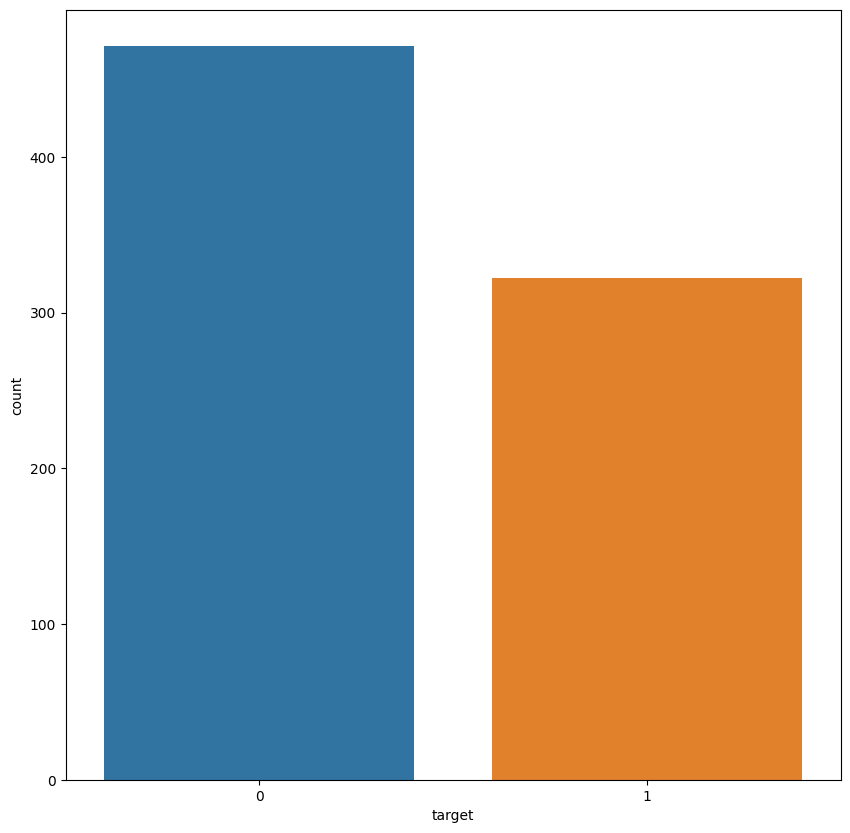

In [ ]:
plt.figure(figsize = (10,10))


sns.countplot(x = "target",data = df)

plt.show()

We preprocess all the images 

In [ ]:
def preprocessing_image(filepath):
  img = cv2.imread(filepath) #read
  img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) #convert
  img = cv2.resize(img,(196,196))  # resize
  img = img / 255 #scale
  return img 

We create numpy array X and y . X are 998 images with (196,196,3) shape, y the target is (998,) shape

In [ ]:
def create_format_dataset(dataframe):
  X = []
  y = []
  for f,t in dataframe.values:
    X.append(preprocessing_image(f))
    y.append(t)
  
  return np.array(X),np.array(y)

In [ ]:
X, y = create_format_dataset(df)

In [ ]:
X.shape,y.shape

we split the data in train and test 

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,stratify = y)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

In [ ]:
model = Sequential()

model.add(Conv2D(128,(2,2),input_shape = (196,196,3),activation='relu'))
model.add(Conv2D(64,(2,2),activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32,(2,2),activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128))
model.add(Dense(1,activation= "sigmoid"))

In [ ]:
model.summary()

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss',patience = 10,restore_best_weights=True)]
model.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 30,batch_size = 32,callbacks = callbacks)

Epoch 1/30
20/20 [==============================] - 19s 253ms/step - loss: 1.3755 - accuracy: 0.6625 - val_loss: 0.3257 - val_accuracy: 0.8239
Epoch 2/30
20/20 [==============================] - 3s 145ms/step - loss: 0.3728 - accuracy: 0.8375 - val_loss: 0.2098 - val_accuracy: 0.9623
Epoch 3/30
20/20 [==============================] - 3s 136ms/step - loss: 0.2238 - accuracy: 0.9038 - val_loss: 0.1348 - val_accuracy: 0.9560
Epoch 4/30
20/20 [==============================] - 3s 133ms/step - loss: 0.1854 - accuracy: 0.9196 - val_loss: 0.1380 - val_accuracy: 0.9371
Epoch 5/30
20/20 [==============================] - 3s 143ms/step - loss: 0.1649 - accuracy: 0.9369 - val_loss: 0.1006 - val_accuracy: 0.9623
Epoch 6/30
20/20 [==============================] - 3s 134ms/step - loss: 0.0919 - accuracy: 0.9637 - val_loss: 0.0844 - val_accuracy: 0.9686
Epoch 7/30
20/20 [==============================] - 3s 136ms/step - loss: 0.0852 - accuracy: 0.9653 - val_loss: 0.1324 - val_accuracy: 0.9560
Epoch

In [ ]:
y_pred = model.predict(X_test)
print(y_pred)

In [ ]:
y_pred = y_pred.reshape(-1)
print(y_pred)
y_pred[y_pred<0.5] = 0
y_pred[y_pred>=0.5] = 1
y_pred = y_pred.astype('int')

[1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0
 0 1 0 0 1 1 1 0 1 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1
 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0
 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0
 1 0 0 0 0 0 1 0 1 0 1]


In [ ]:
y_pred

In [ ]:
plt.figure(figsize = (20,10))

sns.heatmap(confusion_matrix(y_test,y_pred),annot = True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        94
           1       1.00      1.00      1.00        65

    accuracy                           1.00       159
   macro avg       1.00      1.00      1.00       159
weighted avg       1.00      1.00      1.00       159



In [ ]:
import joblib
joblib.dump(model,"firedetection.h5")

In [ ]:
model.save("fire.h5")

In [ ]:
new_pred=joblib.load("firedetections.joblib")